## **Business Context**
You are provided an e-commerce data set from a real-world organisation to perform customer segmentation with clustering models to improve marketing efforts (SAS, 2024). It is a transnational data set with customers from five continents (Oceania, North America, Europe, Africa, and Asia) and 47 countries.

The data set contains 951,668 rows, each representing a product a customer ordered. The data set contains details about the customer (e.g. location, product type, loyalty member) and order (e.g. days to delivery, delivery date, order date, cost, quantity ordered, profit) based on orders between 1 January 2012 and 30 December 2016.

Your task is to develop a robust customer segmentation to assist the e-commerce company in understanding and serving its customers better. This will help to have a more customer-centric focus, improving marketing efficiency. Therefore, you’ll explore the data, employ preprocessing and feature engineering, dimension reduction, and perform customer segmentation with clustering models.


## **Objective**
Apply statistical and ML methods to perform customer segmentation with clustering techniques.

In [ ]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import scipy.cluster.hierarchy as sch
import matplotlib.cm as cm
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE

In [ ]:
!pip3 install gdown

In [ ]:
!gdown ''

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1S5wniOV5_5htDfUFeZhlCLibvtihNLKK
From (redirected): https://drive.google.com/uc?export=download&id=1S5wniOV5_5htDfUFeZhlCLibvtihNLKK&confirm=t&uuid=fb55e417-c45d-4a7c-ac02-2a8c5f097867
To: /content/CUSTOMERS_CLEAN.csv
100% 191M/191M [00:08<00:00, 23.2MB/s]


In [ ]:
df = pd.read_csv('CUSTOMERS_CLEAN.csv')

## Exploratory data analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951669 entries, 0 to 951668
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Quantity              951669 non-null  int64 
 1   City                  951534 non-null  object
 2   Continent             951669 non-null  object
 3   Postal_Code           947953 non-null  object
 4   State_Province        834477 non-null  object
 5   Order_Date            951669 non-null  object
 6   Delivery_Date         951669 non-null  object
 7   Total Revenue         951669 non-null  object
 8   Unit Cost             951669 non-null  object
 9   Discount              951669 non-null  object
 10  OrderTypeLabel        951669 non-null  object
 11  CustomerCountryLabel  951669 non-null  object
 12  Customer_BirthDate    951669 non-null  object
 13  Customer_Group        951669 non-null  object
 14  Customer_Type         951669 non-null  object
 15  Order ID         

In [ ]:
df.describe()

,Quantity,Order ID,Days to Delivery,Loyalty Num,Customer ID
count,951669.000000,9.516690e+05,951669.000000,951669.000000,951669.000000
mean,1.678438,1.236943e+09,1.056107,66.534079,45440.602683
std,0.899914,4.273202e+06,2.065725,46.476795,27214.145206
min,1.000000,1.230000e+09,0.000000,0.000000,1.000000
25%,1.000000,1.233081e+09,0.000000,0.000000,22139.000000
50%,1.000000,1.236755e+09,0.000000,99.000000,44140.000000
75%,2.000000,1.240689e+09,1.000000,99.000000,70411.000000
max,10.000000,1.244338e+09,32.000000,99.000000,94254.000000


In [ ]:
df.describe(include='object')

,City,Continent,Postal_Code,State_Province,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Profit
count,951534,951669,947953,834477,951669,951669,951669,951669,951669,951669,951669,951669,951669,951669,951669
unique,10505,5,19339,271,1825,1840,6894,1883,5,3,47,4368,3,7,3520
top,London,Europe,75008,Ile-de-France,28FEB2014,28FEB2014,$55.40,$45.60,.,Retail Sale,United States,30JUN1968,Orion Club Gold members,Orion Club Gold members high activity,($0.20)
freq,47573,653684,4249,74897,1096,967,3301,4435,942517,715970,232258,549,483438,223488,86795


## Data Preprocessing

In [ ]:
#checking for duplicates
df.duplicated().sum()

21

In [ ]:
# Removing 21 duplicates in dataframe
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [ ]:
#checking for null
df.isnull().sum()

Quantity                     0
City                       135
Continent                    0
Postal_Code               3716
State_Province          117192
Order_Date                   0
Delivery_Date                0
Total Revenue                0
Unit Cost                    0
Discount                     0
OrderTypeLabel               0
CustomerCountryLabel         0
Customer_BirthDate           0
Customer_Group               0
Customer_Type                0
Order ID                     0
Profit                       0
Days to Delivery             0
Loyalty Num                  0
Customer ID                  0
dtype: int64

In [ ]:
# Replacing null values
df = df.fillna('')
df.isnull().sum().sum()

0

In [ ]:
len(df['Customer ID'].unique())

68300

In [ ]:
# transforming the data to standardise and for efficient programming
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d%b%Y')
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'], format='%d%b%Y')
df['Customer_BirthDate'] = pd.to_datetime(df['Customer_BirthDate'], format='%d%b%Y')
df['Total Revenue'] = df['Total Revenue'].replace('[\$,]', '', regex=True).astype(float)
df['Discount']=df['Discount'].replace('[\%]', '', regex=True).replace('   .','0').astype(int)
df['Profit'] = df['Profit'].replace('[\(\)\$,]', '', regex=True).astype(float)
df['Unit Cost'] = df['Unit Cost'].replace('[\$,]', '', regex=True).astype(float)

In [ ]:
# checking the status of features after transformations
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 951648 entries, 0 to 951668
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Quantity              951648 non-null  int64         
 1   City                  951648 non-null  object        
 2   Continent             951648 non-null  object        
 3   Postal_Code           951648 non-null  object        
 4   State_Province        951648 non-null  object        
 5   Order_Date            951648 non-null  datetime64[ns]
 6   Delivery_Date         951648 non-null  datetime64[ns]
 7   Total Revenue         951648 non-null  float64       
 8   Unit Cost             951648 non-null  float64       
 9   Discount              951648 non-null  int64         
 10  OrderTypeLabel        951648 non-null  object        
 11  CustomerCountryLabel  951648 non-null  object        
 12  Customer_BirthDate    951648 non-null  datetime64[ns]
 13  Cust

In [ ]:
# the numerical columns are filtered and assigned to dataframe
num_df = df[['Quantity','Total Revenue','Unit Cost','Discount','Profit','Days to Delivery','Loyalty Num']].copy()
num_df

,Quantity,Total Revenue,Unit Cost,Discount,Profit,Days to Delivery,Loyalty Num
0,3,28.50,9.1,0,1.20,6,99
1,2,113.40,56.9,0,0.40,3,99
2,2,41.00,18.5,0,4.00,3,99
3,1,35.20,29.6,0,5.60,2,0
4,1,24.70,23.6,0,1.10,3,99
...,...,...,...,...,...,...,...
951664,2,89.00,42.4,0,4.20,0,0
951665,4,93.60,21.0,0,9.60,0,0
951666,4,114.40,25.9,0,10.80,2,0
951667,1,335.40,327.3,0,8.10,2,0


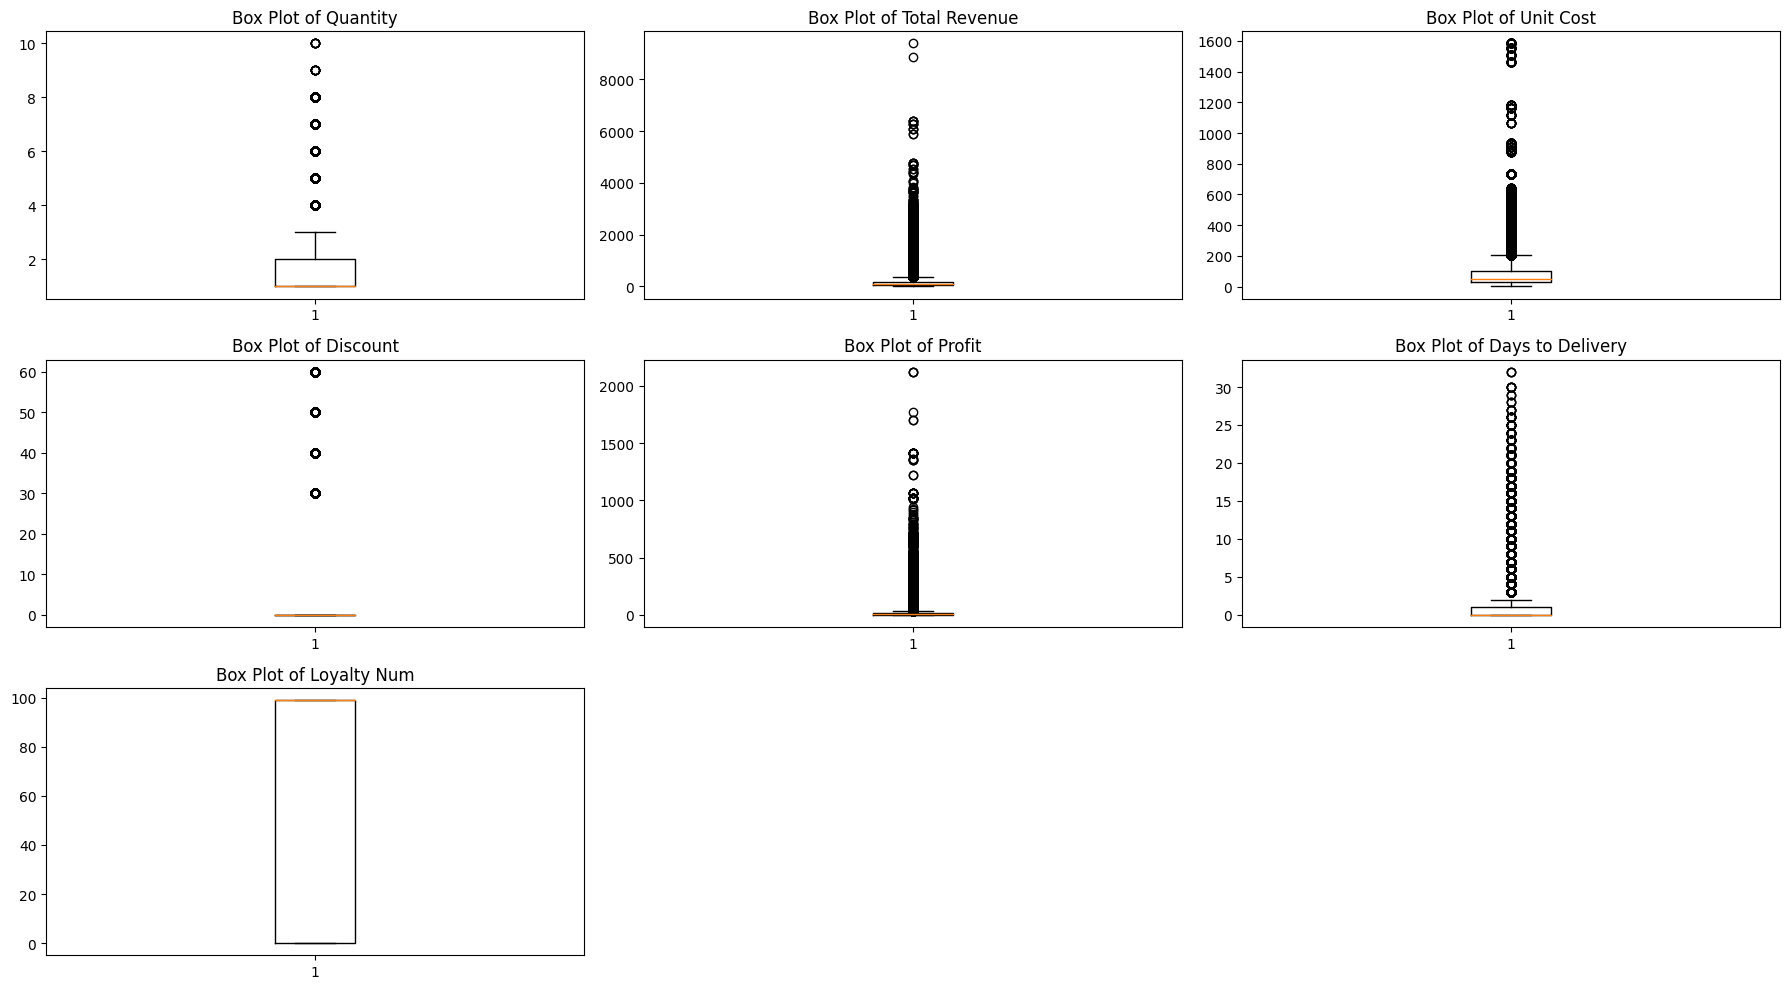

In [ ]:
# visualising numerical columns in boxplots to identify extreme values
plt.figure(figsize=(18, 10))
plt.subplot(3, 3, 1)
plt.boxplot(df['Quantity'])
plt.title('Box Plot of Quantity')

plt.subplot(3, 3, 2)
plt.boxplot(df['Total Revenue'])
plt.title('Box Plot of Total Revenue')

plt.subplot(3, 3, 3)
plt.boxplot(df['Unit Cost'])
plt.title('Box Plot of Unit Cost')

plt.subplot(3, 3, 4)
plt.boxplot(df['Discount'])
plt.title('Box Plot of Discount')

plt.subplot(3, 3, 5)
plt.boxplot(df['Profit'])
plt.title('Box Plot of Profit')

plt.subplot(3, 3, 6)
plt.boxplot(df['Days to Delivery'])
plt.title('Box Plot of Days to Delivery')

plt.subplot(3, 3, 7)
plt.boxplot(df['Loyalty Num'])
plt.title('Box Plot of Loyalty Num')

plt.tight_layout()
plt.show()

Detecting outliers using IQR

In [ ]:
outlier_df = num_df.copy()
for col in outlier_df.columns:

  Q1 = outlier_df[col].quantile(0.25)
  Q3 = outlier_df[col].quantile(0.75)
  IQR = Q3 - Q1

  outlier_df[f'Outlier_{col}'] = ((outlier_df[col] < (Q1 - 1.5 * IQR)) | (outlier_df[col] > (Q3 + 1.5 * IQR))).astype(int)

outlier_df

,Quantity,Total Revenue,Unit Cost,Discount,Profit,Days to Delivery,Loyalty Num,Outlier_Quantity,Outlier_Total Revenue,Outlier_Unit Cost,Outlier_Discount,Outlier_Profit,Outlier_Days to Delivery,Outlier_Loyalty Num
0,3,28.50,9.1,0,1.20,6,99,0,0,0,0,0,1,0
1,2,113.40,56.9,0,0.40,3,99,0,0,0,0,0,1,0
2,2,41.00,18.5,0,4.00,3,99,0,0,0,0,0,1,0
3,1,35.20,29.6,0,5.60,2,0,0,0,0,0,0,0,0
4,1,24.70,23.6,0,1.10,3,99,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951664,2,89.00,42.4,0,4.20,0,0,0,0,0,0,0,0,0
951665,4,93.60,21.0,0,9.60,0,0,1,0,0,0,0,0,0
951666,4,114.40,25.9,0,10.80,2,0,1,0,0,0,0,0,0
951667,1,335.40,327.3,0,8.10,2,0,0,0,1,0,0,0,0




> The detection of outliers in numerical columns are performed using the IQR (interquartile range) method which generates values in the range between 25th percentile and 75th percentile. The outliers were then calculated using the 1.5 IQR rule, designating any value greater than Q3 + (1.5 x IQR) and any value less than Q1 - (1.5 x IQR) as an outlier. The ‘0’ corresponding to each sample represents a normal behaviour in the features and ‘1’ represents an outlier for that respective feature.



# Feature Engineering

Creating new features for frequency, recency, CLV, average unit cost, and customer age

In [ ]:
df['Frequency'] = df.groupby('Customer ID')['Order ID'].transform('count')
df['Frequency']

0         31
1         20
2         20
3         20
4          6
          ..
951664    13
951665    13
951666     7
951667     7
951668     8
Name: Frequency, Length: 951648, dtype: int64

In [ ]:
df['Recency'] = (pd.to_datetime('today') - df['Delivery_Date']).dt.days
df['Recency']

0         4517
1         4520
2         4520
3         4521
4         4520
          ... 
951664    2698
951665    2698
951666    2696
951667    2696
951668    2698
Name: Recency, Length: 951648, dtype: int64

In [ ]:
df['CLV'] = df.groupby('Customer ID')['Total Revenue'].transform('sum')
df['CLV']

0         3732.70
1         2166.30
2         2166.30
3         2566.00
4         1156.30
           ...   
951664    1612.70
951665    1612.70
951666    1213.30
951667    1213.30
951668     878.08
Name: CLV, Length: 951648, dtype: float64

In [ ]:
df['Avg_UnitCost'] = df.groupby('Customer ID')['Unit Cost'].transform('mean')
df['Avg_UnitCost']

0          60.206452
1          66.280000
2          66.280000
3          74.775000
4          74.300000
             ...    
951664     59.400000
951665     59.400000
951666    148.928571
951667    148.928571
951668     73.362500
Name: Avg_UnitCost, Length: 951648, dtype: float64

In [ ]:
today = pd.Timestamp('now')
df['customer_age'] = (today - df['Customer_BirthDate']).dt.days // 365
df['customer_age']

0         12
1         12
2         12
3         12
4         12
          ..
951664     7
951665     7
951666     7
951667     7
951668     7
Name: customer_age, Length: 951648, dtype: int64

## Data Transformations

In [ ]:
# aggregation operations and groupy() function was used to get one customer per row.
agg_operations = {
    'Frequency':'max',
    'Recency':'min',
    'CLV':'max',
    'customer_age':'max',
    'Avg_UnitCost':'mean'
}

df = df.groupby('Customer ID').agg(agg_operations).reset_index()
df_aggr = df[['Frequency','Recency','CLV','customer_age','Avg_UnitCost']]

## Clustering

For more efficient programming, incorporated the pipeline method to use column transformers and k-means clustering.

In [ ]:
preprocessor = ColumnTransformer(
  transformers=[('num', StandardScaler(), ['Frequency','Recency','CLV','customer_age','Avg_UnitCost'])]
)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=10, n_init=10)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('kmeans', kmeans)])
pipeline.fit(df_aggr)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Frequency', 'Recency',
                                                   'CLV', 'customer_age',
                                                   'Avg_UnitCost'])])),
                ('kmeans', KMeans(n_clusters=3, n_init=10, random_state=10))])

Getting preprocessed data from pipeline

In [ ]:
df_preprocessed = pipeline.named_steps['preprocessor'].transform(df_aggr)

Dimensionality reduction using PCA

In [ ]:
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(df_preprocessed), columns=['pca_1', 'pca_2'])

Elbow method

In [ ]:
wcss = []

for k in range(2, 16):
  pipeline.named_steps['kmeans'].set_params(n_clusters=k)
  pipeline.fit(df_aggr)
  wcss.append(pipeline.named_steps['kmeans'].inertia_)

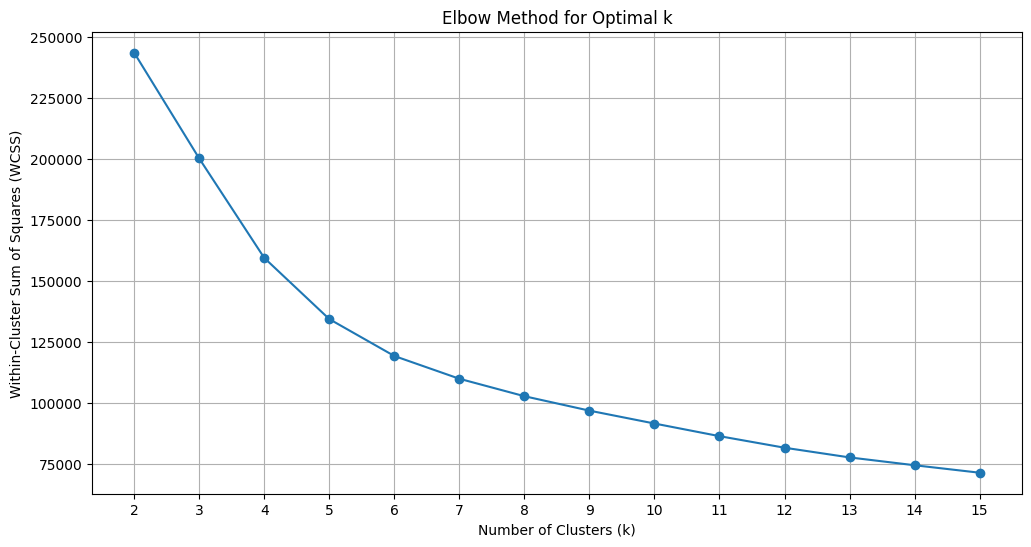

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(0, len(wcss)), range(2, len(wcss) + 2))
plt.grid(True)
plt.show()

Silhouette analysis

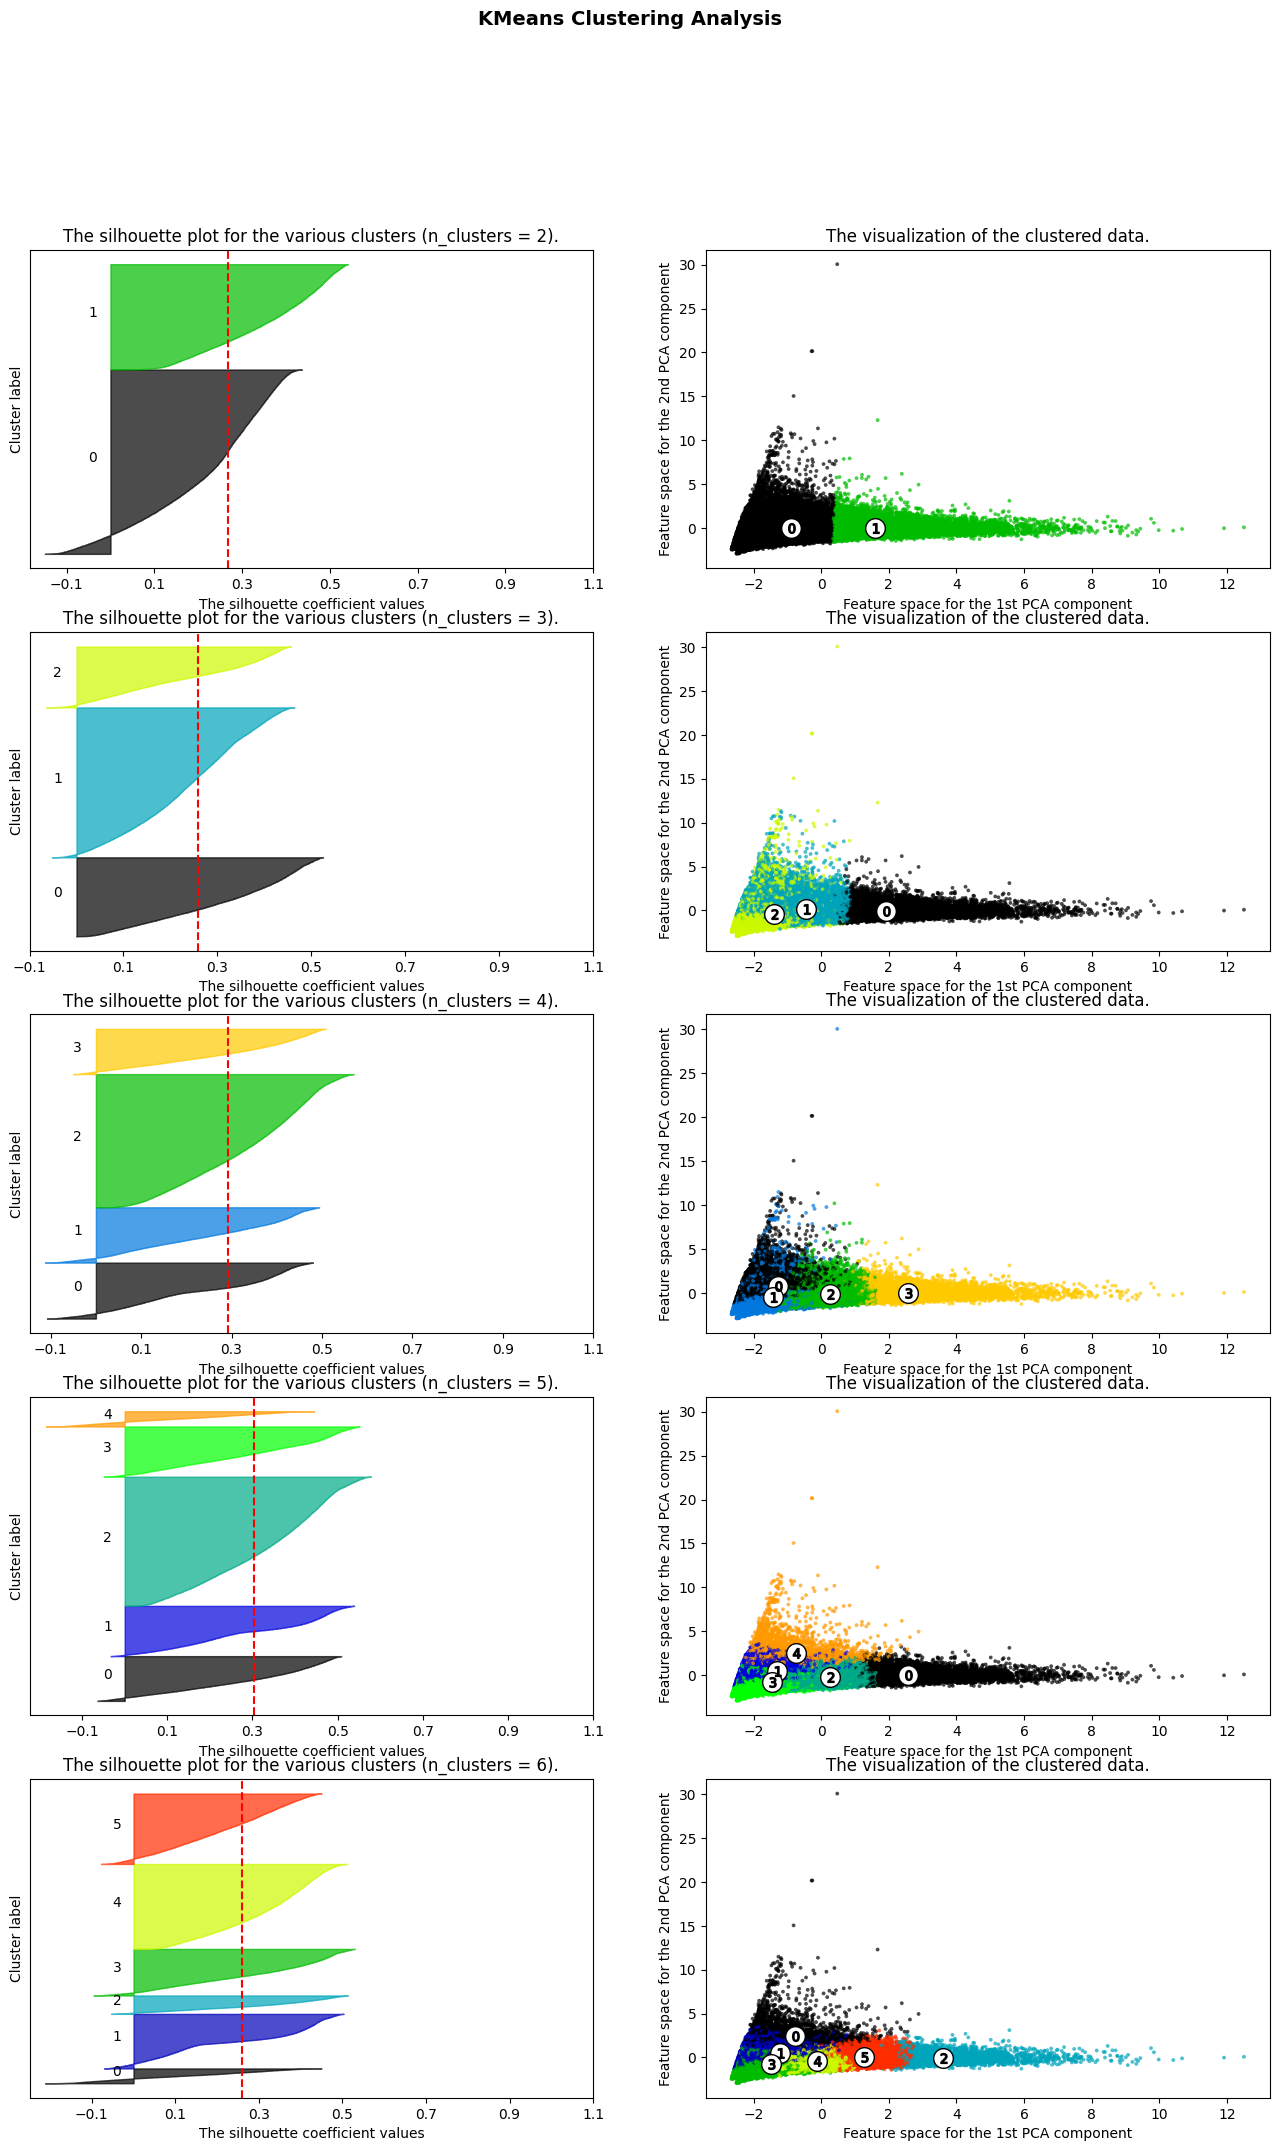

In [ ]:
silhouette_avgs = []
fig, axes = plt.subplots(5, 2, figsize=(16, 24))
fig.suptitle("KMeans Clustering Analysis", fontsize=14, fontweight='bold')

for k in range(2, 7):
  ax1, ax2 = axes[k-2]
  pipeline.named_steps['kmeans'].set_params(n_clusters=k)
  pipeline.fit(df_aggr)

  labels = pipeline.named_steps['kmeans'].labels_
  silhouette_avg = silhouette_score(df_preprocessed, labels)
  silhouette_avgs.append(silhouette_avg)
  sample_silhouette_values = silhouette_samples(df_preprocessed, labels)

  y_lower = 10
  for i in range(k):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

  ax1.set_title(f"The silhouette plot for the various clusters (n_clusters = {k}).")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax1.set_yticks([])
  ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

  colors = cm.nipy_spectral(labels.astype(float) / k)
  ax2.scatter(pca_df['pca_1'], pca_df['pca_2'], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
  centers = pca.transform(pipeline.named_steps['kmeans'].cluster_centers_)
  ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
  for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
  ax2.set_title("The visualization of the clustered data.")
  ax2.set_xlabel("Feature space for the 1st PCA component")
  ax2.set_ylabel("Feature space for the 2nd PCA component")

plt.show()

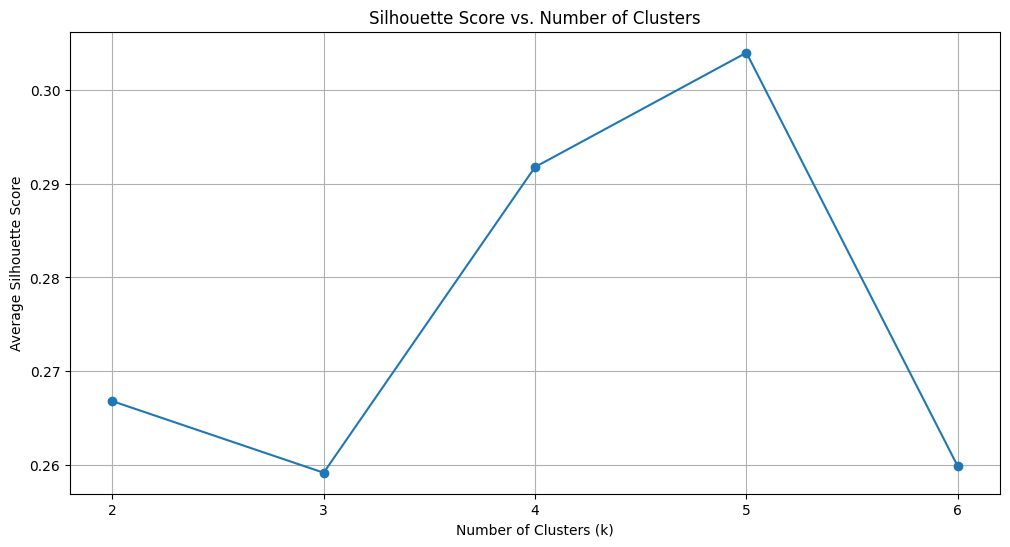

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(silhouette_avgs, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.xticks(range(0, len(silhouette_avgs)), range(2, len(silhouette_avgs) + 2))
plt.grid(True)
plt.show()

In [ ]:
# from the above visualisation we found out the best K as 5
k=5
pipeline.named_steps['kmeans'].set_params(n_clusters=k)
pipeline.fit(df_aggr)
labels = pipeline.named_steps['kmeans'].labels_
labels

array([0, 2, 3, ..., 0, 2, 3], dtype=int32)

In [ ]:
df['cluster'] = labels
df

,Customer ID,Frequency,Recency,CLV,customer_age,Avg_UnitCost,cluster
0,1,35,2715,4322.70,10,89.622857,0
1,3,20,2817,2821.00,12,90.505000,2
2,4,9,3806,782.67,11,37.195556,3
3,5,19,2703,2810.98,12,107.947368,2
4,6,15,2888,1604.58,11,52.526667,2
...,...,...,...,...,...,...,...
68295,94248,6,3452,982.47,10,93.250000,3
68296,94250,4,3617,927.78,9,115.075000,1
68297,94252,49,2745,9311.27,12,77.312245,0
68298,94253,8,3041,1453.20,11,74.000000,2


PCA for visualisation

In [ ]:
pca_df['cluster'] = labels
pca_df

,pca_1,pca_2,cluster
0,2.075740,0.766967,0
1,1.179899,-0.038597,2
2,-1.385117,-1.394633,3
3,1.252488,0.416408,2
4,0.069482,-0.562502,2
...,...,...,...
68295,-1.342133,0.473760,3
68296,-1.851438,1.281613,1
68297,5.121041,-0.084895,0
68298,-0.463710,-0.116921,2


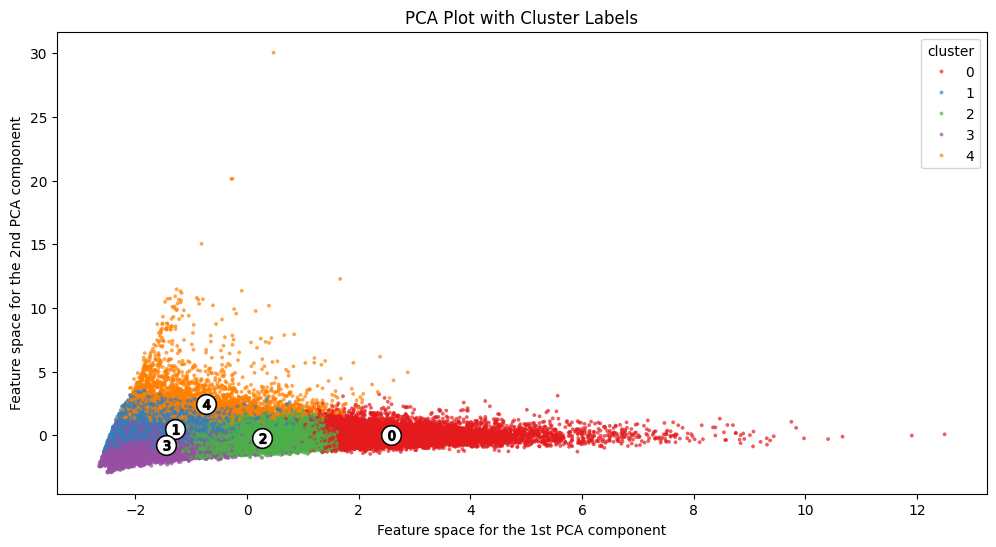

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
  x='pca_1',
  y='pca_2',
  hue='cluster',
  data=pca_df,
  palette='Set1',
  marker='.',
  s=30,
  linewidth=0,
  alpha=0.7
)
centers = pca.transform(pipeline.named_steps['kmeans'].cluster_centers_)
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], color="white", alpha=1, s=200, edgecolor='k', legend=False)
for i, c in enumerate(centers):
  plt.scatter(x=c[0], y=c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
plt.title('PCA Plot with Cluster Labels')
plt.xlabel("Feature space for the 1st PCA component")
plt.ylabel("Feature space for the 2nd PCA component")
plt.show()

t-SNE for visualisation

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df_preprocessed)
df_tsne = pd.DataFrame(data=tsne_result, columns=['t-SNE1', 't-SNE2'])


In [ ]:
df_tsne['cluster'] = labels
df_tsne

,t-SNE1,t-SNE2,cluster
0,34.935356,102.943993,0
1,64.544464,-41.361870,2
2,-69.790833,-43.933167,3
3,50.206451,-35.901707,2
4,43.267982,-5.462664,2
...,...,...,...
68295,-56.383526,25.241314,3
68296,-99.817558,63.826565,1
68297,94.423813,42.129135,0
68298,-29.093878,-5.581004,2


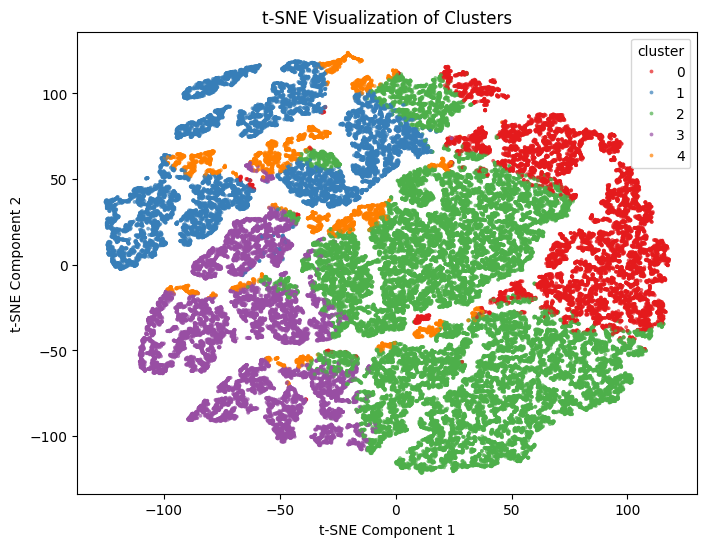

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
  x='t-SNE1',
  y='t-SNE2',
  hue='cluster',
  data=df_tsne,
  palette='Set1',
  marker='.',
  s=30,
  linewidth=0,
  alpha=0.7
)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

BoxPlot Visualisation (Features Vs Clusters)

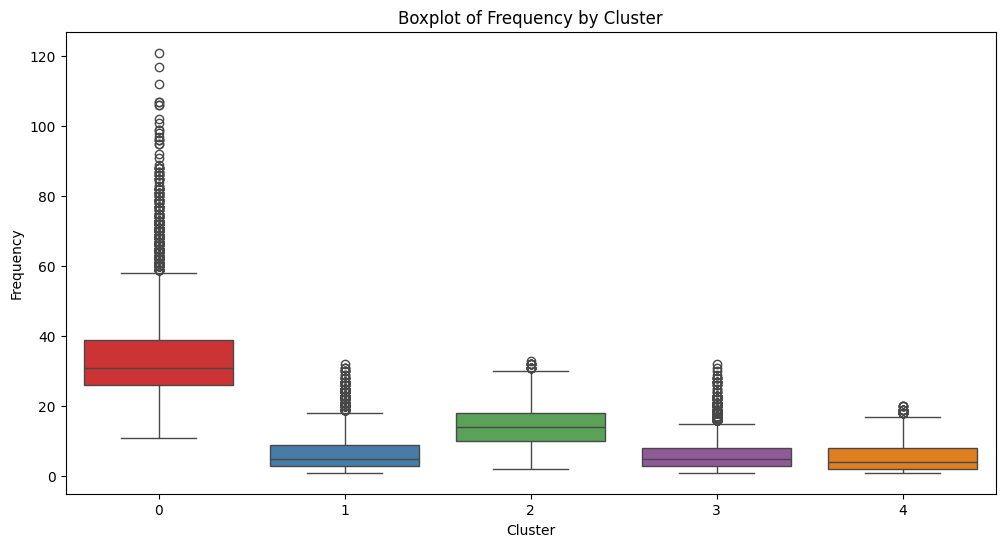

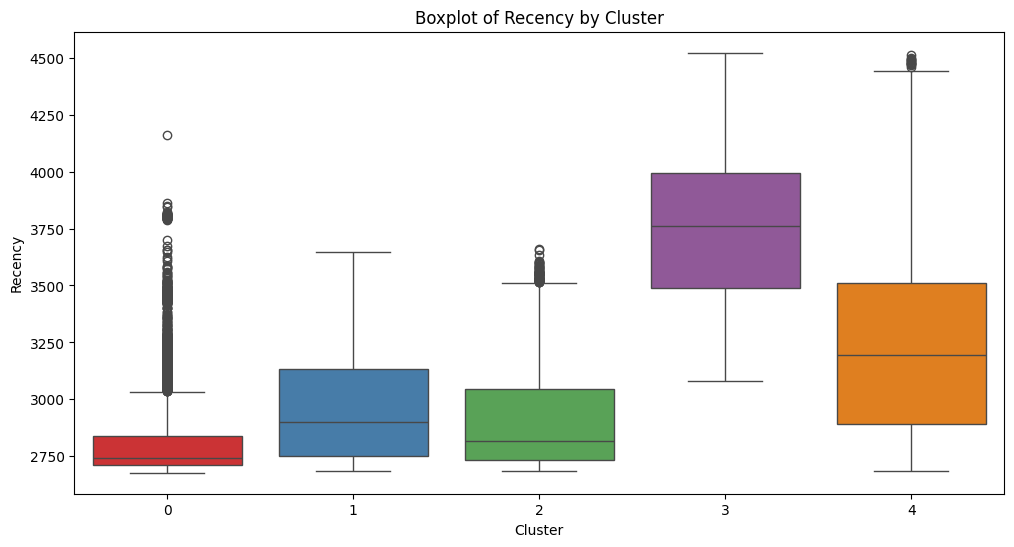

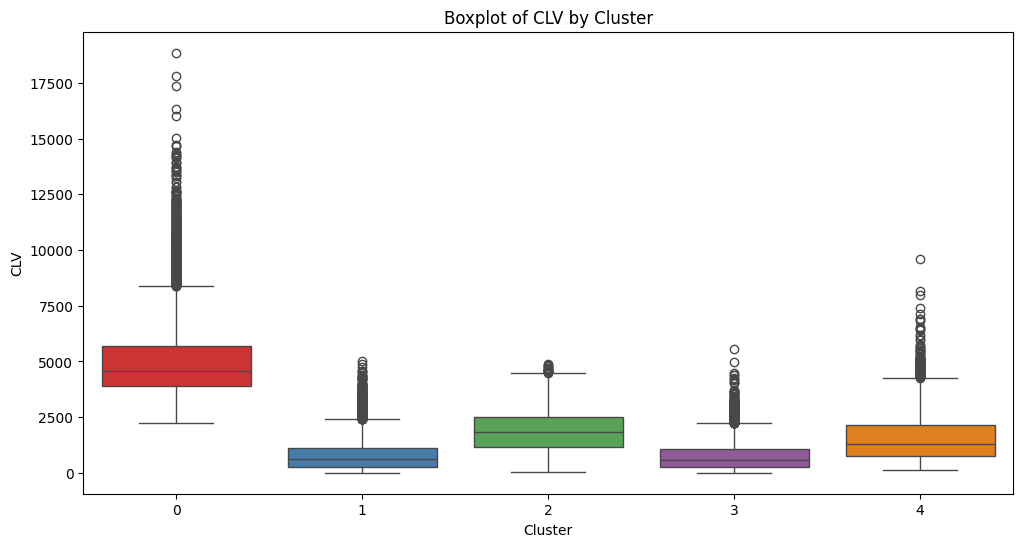

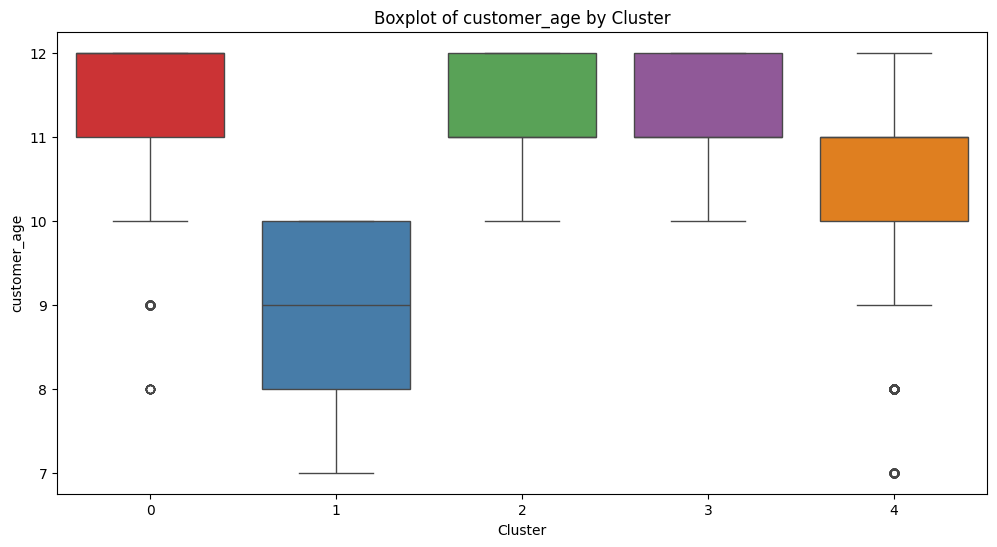

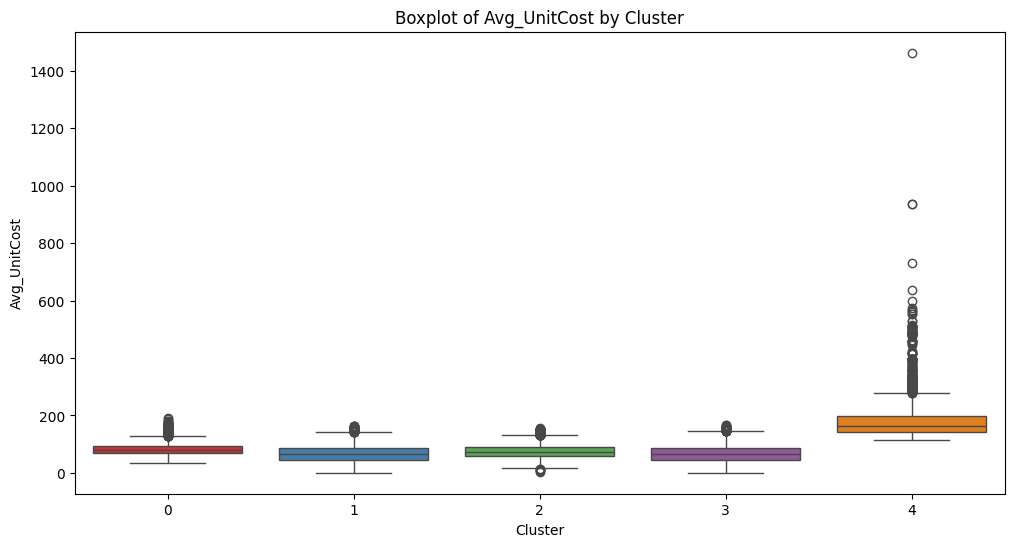

In [ ]:
for column in df_aggr[['Frequency','Recency','CLV','customer_age','Avg_UnitCost']]:
  plt.figure(figsize=(12, 6))
  sns.boxplot(
    x='cluster',
    y=column,
    data=df,
    hue='cluster',
    legend=False,
    palette='Set1'
  )
  plt.title(f'Boxplot of {column} by Cluster')
  plt.xlabel('Cluster')
  plt.ylabel(column)
  plt.show()

Agglomerative Clustering

Since the notebook was crashing due to huge amout of data, data sampled to 10000 rows to fix the issue.

In [ ]:
small_df = df_aggr.sample(n= 10000).reset_index(drop = True)

In [ ]:
agglo_cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='average')
small_df['cluster'] = agglo_cluster.fit_predict(small_df)
small_df

,Frequency,Recency,CLV,customer_age,Avg_UnitCost,cluster
0,5,3798,1044.6,11,112.680000,0
1,44,2693,7920.4,12,96.145455,1
2,12,2904,877.6,12,49.291667,0
3,26,2730,3492.6,12,71.446154,0
4,11,2803,999.3,11,48.245455,0
...,...,...,...,...,...,...
9995,2,3957,240.4,10,89.500000,0
9996,12,3645,1166.3,12,60.491667,0
9997,18,2869,1525.8,11,64.772222,0
9998,25,2727,2390.9,12,54.564000,0


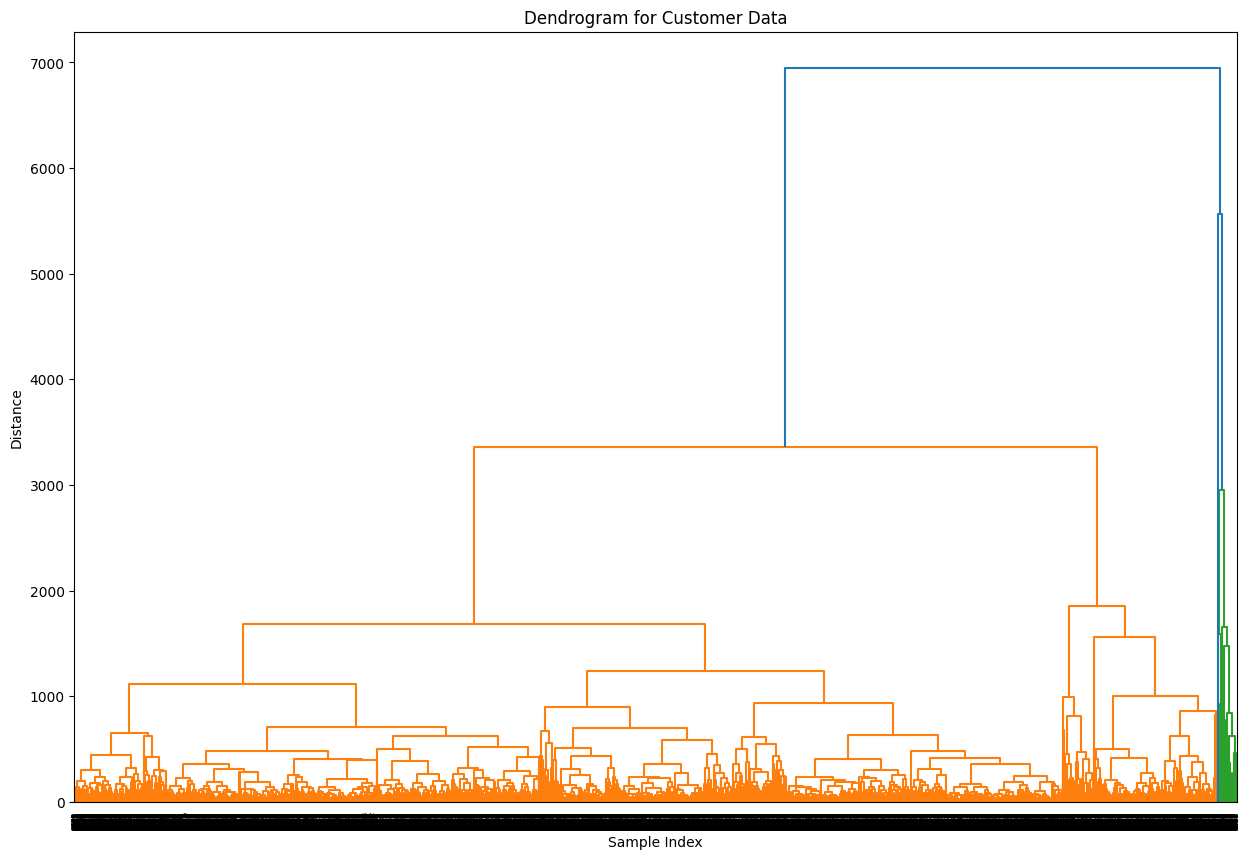

In [ ]:
Z = linkage(small_df, method='average')
plt.figure(figsize=(15, 10))
dendrogram(Z)
plt.title('Dendrogram for Customer Data')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


> The objective was to develop a robust customer segmentation to assist the e-commerce company in understanding and serving its customers better. The dataset had 20 features to choose on which features or feature combinations can help in customer segmentation. The steps followed are exploratory data analysis, data preprocessing, feature engineering and determining the best number of clusters(k) using the Elbow and Silhouette score methods and based on optimum number of ‘k’, performing the k-means clustering. The resulting clusters can then be visualised in 2D by reducing the dimensions using PCA and t-SNE models.


### Reference:
SAS, 2024. CUSTOMERS_CLEAN [Data set]. SAS. Last revised on 15 December 2021. [Accessed 20 February 2024].